# Exercise 11 Part 2: Vision Transformers
**Summer Semester 2024**

**Author**: Stefan Baumann (stefan.baumann@lmu.de)

### Task: Implement & Train a ViT
Refer to the lecture and the original ViT paper (*AN IMAGE IS WORTH 16X16 WORDS: TRANSFORMERS FOR IMAGE RECOGNITION AT SCALE*, Dosovitskiy et al., 2020) for details. The naming of the hyperparameters is as in the aforementioned paper.

Similar to Part 1, you're expected to implement each block yourself, although you're allowed to use blocks like `torch.nn.MultiheadAttention`, `torch.nn.Linear`, etc. Implement the blocks as in the original ViT paper. No usage of things such as full pre-made FFN/self-attention blocks or full transformer implementations like `torchvision.models.vision_transformer.VisionTransformer` is allowed for this exercise. You're expected to do full vectorized implementations in native PyTorch (again, einops is allowed) without relying on Python for loops for things such as patching etc.

Some relevant details:
- For simplicity of implementation, we will use a randomly (Gaussian with mean 0 and variance 1) initialized *learnable* positional embedding, not a Fourier/sinusoidal one.
- Don't forget about all of the layer norms!
- Consider the `batch_first` attribute of `nn.MultiheadAttention`, should you use that class
- We'll make the standard assumption that $\mathrm{dim}_\text{head} = \mathrm{dim}_\text{hidden} / N_\text{heads}$

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import math
import time

# Optional
import einops

device = 'mps' if torch.backends.mps.is_available() else ('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device "{device}".')

Using device "mps".


/Users/janinaalicamattes/miniforge3/envs/pytorch-py11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
class ResidualModule(nn.Module):
    def __init__(
            self,
            inner_module: nn.Module
        ):
        super().__init__()
        self.inner_module = inner_module

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return x + self.inner_module(x)

class FeedForwardBlock(nn.Module):
    """ FeedForwardBlock class for the MLP of a transformer block in the Transformer Encoder.
        The linear MLP layers are local and translationally equivariant,
        while the self-attention layers are global and permutation invariant.

        Args:
            hidden_size (int): Hidden size of the model.
            mlp_size (int): Size of the MLP.
            p_dropout (float): Dropout probability.

        Returns:
            torch.Tensor: Output tensor of the feedforward block.
    """

    def __init__(
            self,
            hidden_size: int,
            mlp_size: int,
            p_dropout: float
        ):
        super().__init__()
        self.dropout = p_dropout
        self.hidden_size = hidden_size # kept fixed
        self.mlp_size = mlp_size

        self.linear1 = nn.Linear(self.hidden_size, self.mlp_size)
        self.dropout1 = nn.Dropout(self.dropout)
        self.gelu = nn.GELU()
        self.linear2 = nn.Linear(self.mlp_size, self.hidden_size)
        self.dropout2 = nn.Dropout(self.dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.linear1(x)
        x = self.gelu(x)
        x = self.dropout1(x)
        x = self.linear2(x)
        x = self.dropout2(x)
        return x

class SelfAttentionTransformerBlock(nn.Module):
    """ SelfAttentionTransformerBlock class for the transformer block in the Transformer Encoder.
        The linear MLP layers are local and translationally equivariant,
        while the self-attention layers are global and permutation invariant.

        Args:
            hidden_size (int): Hidden size of the model.
            n_heads (int): Number of heads in the multi-head self-attention.
            p_dropout (float): Dropout probability.

        Returns:
            torch.Tensor: Output tensor of the transformer block.
    """

    def __init__(
            self,
            hidden_size: int,
            n_heads: int,
            p_dropout: float
        ):
        super().__init__()
        self.hidden_size = hidden_size
        self.n_heads = n_heads
        self.p_dropout = p_dropout
        self.mlp_size = self.hidden_size * 4 # Standard in the literature

        # Layer normalization - important to stabilize training
        self.norm1 = nn.LayerNorm(self.hidden_size)
        self.norm2 = nn.LayerNorm(self.hidden_size)

        # Multi-head self-attention
        self.mha = nn.MultiheadAttention(self.hidden_size, self.n_heads, dropout=p_dropout, batch_first=True)

        # MLP block
        self.mlp = FeedForwardBlock(self.hidden_size, self.mlp_size, self.p_dropout)

        # Dropout
        self.dropout = nn.Dropout(self.p_dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        # Residual connection
        residual = x

        # Self-attention (global and permutation invariant)
        x = self.norm1(x)
        x = self.mha(x, x, x)[0]
        x = self.dropout(x)
        # Residual connection
        x = x + residual

        # Residual connection
        residual = x

        # MLP (local and translationally equivariant)
        x = self.norm2(x)
        x = self.mlp(x)
        x = self.dropout(x)
        # Residual connection
        x = x + residual

        return x


class VisionTransformer(nn.Module):
    def __init__(
            self,
            in_channels: int = 3,
            patch_size: int = 4,
            image_size: int = 32,
            layers: int = 6,
            hidden_size: int = 256,
            mlp_size: int = 512,
            n_heads: int = 8,
            num_classes: int = 10,
            p_dropout: float = 0.2,
        ):
        super().__init__()

        self.in_channels = in_channels
        self.patch_size = patch_size
        self.image_size = image_size
        self.layers = layers
        self.hidden_size = hidden_size
        self.mlp_size = mlp_size
        self.n_heads = n_heads
        self.num_classes = num_classes
        self.p_dropout = p_dropout


        # ---------------------------------
        # ------ Transformer Encoder ------
        # ---------------------------------

        # Image patches / token
        self.num_patches = (self.image_size // self.patch_size) ** 2 # Number of patches (L) or tokens
        self.patch_dim = self.in_channels * (self.patch_size ** 2)   # Dimension of the patch after flattening (D)

        # Patch embedding - linear projection of the patches
        self.patch_embed = nn.Linear(self.patch_dim, self.hidden_size)

        # Positional encoding - learnable positional embeddings
        self.pos_embed = nn.Parameter(torch.randn(1, self.num_patches + 1, hidden_size))

        # CLS token - classification token
        self.cls_token = nn.Parameter(torch.zeros(1, 1, self.hidden_size))

        # Transformer blocks
        self.transformer_blocks = nn.Sequential(*[
            SelfAttentionTransformerBlock(self.hidden_size, self.n_heads, self.p_dropout)
            for _ in range(self.layers)
        ])

        # Dropout
        self.dropout = nn.Dropout(self.p_dropout)

        # ---------------------------------
        # ------ Classification head ------
        # ---------------------------------

        self.norm = nn.LayerNorm(self.hidden_size)
        self.classification_head = nn.Linear(self.hidden_size, self.num_classes)

        # Initialize weights
        self._init_weights()


    def _init_weights(self):
        # Initialize weights
        self.apply(self._init_layer_weights)

    def _init_layer_weights(self, m):
        # Initialize weights of the model
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)
        elif isinstance(m, nn.LayerNorm):
            nn.init.ones_(m.weight)
            nn.init.zeros_(m.bias)


    def patchify(self, x: torch.Tensor) -> torch.Tensor:
        """Takes an image tensor of shape (B, C, H, W) and transforms it to a sequence of patches (B, L, D), with a learnable linear projection after flattening,
        and a standard additive positional encoding applied. Note that the activations in (Vision) Transformer implementations are
        typically passed around in channels-_last_ layout, different from typical PyTorch norms.

        The linear projection of flattened image patches produces lower-dimensional linear embddings from flattened patches and adds positional embeddings.

        Args:
            x (torch.Tensor): Input tensor of shape (B, C, H, W)

        Returns:
            torch.Tensor: Embedded patch sequence tensor with positional encodings applied and shape (B, L, D)
        """
        B, C, H, W = x.shape

        # Reshape and flatten the image patches
        x = x.reshape(B, C, H // self.patch_size, self.patch_size, W // self.patch_size, self.patch_size)
        x = x.permute(0, 2, 4, 1, 3, 5).contiguous()             # Size: (B, H, W, C, patch_size, patch_size)
        x = x.view(B, -1, C * self.patch_size * self.patch_size) # Size: (B, L, D) with D: C * patch_size * patch_size

        # Linear projection of the patches
        x = self.patch_embed(x)

        # Add positional embeddings
        x = x + self.pos_embed[:, 1:, :]

        # Add CLS token
        cls_token = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_token, x), dim=1)

        # Add positional embeddings for the CLS token
        x[:, 0, :] = x[:, 0, :] + self.pos_embed[:, 0, :]

        return x

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Takes an image tensor of shape (B, C, H, W), applies patching, a standard ViT
           and then an output projection of the CLS token
           to finally create a class logit prediction of shape (B, N_cls)

        Args:
            x (torch.Tensor): Input tensor of shape (B, C, H, W)

        Returns:
            torch.Tensor: Output logits of shape (B, N_cls)
        """
        # Patchify input image + pos embeddings
        x = self.patchify(x)

        # Apply dropout
        x = self.dropout(x)

        # Transformer blocks
        x = self.transformer_blocks(x)

        # Classification head
        x = self.norm(x[:, 0])              # select only the learned CLS token with Size: (B, D)
        x = self.classification_head(x)

        return x


### Training
Do not modify this code!
You are free to modify the four parameters in the first block, although no modifications should be necessary to achieve >70% validation accuracy with a correct transformer implementation.

In [4]:
DATASET_CACHE_DIR = './data'
BATCH_SIZE = 128
LR = 3e-4
N_EPOCHS = 50

100%|██████████| 170498071/170498071 [00:03<00:00, 48744481.98it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Files already downloaded and verified


Training (Epoch 1/50): 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validation accuracy: 0.419


Training (Epoch 2/50): 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validation accuracy: 0.469


Training (Epoch 3/50): 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validation accuracy: 0.519


Training (Epoch 4/50): 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validation accuracy: 0.545


Training (Epoch 5/50): 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validation accuracy: 0.541


Training (Epoch 6/50): 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validation accuracy: 0.566


Training (Epoch 7/50): 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validation accuracy: 0.562


Training (Epoch 8/50): 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validation accuracy: 0.596


Training (Epoch 9/50): 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validation accuracy: 0.600


Training (Epoch 10/50): 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validation accuracy: 0.598


Training (Epoch 11/50): 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validation accuracy: 0.610


Training (Epoch 12/50): 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validation accuracy: 0.618


Training (Epoch 13/50): 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validation accuracy: 0.614


Training (Epoch 14/50): 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validation accuracy: 0.629


Training (Epoch 15/50): 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validation accuracy: 0.636


Training (Epoch 16/50): 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validation accuracy: 0.645


Training (Epoch 17/50): 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validation accuracy: 0.652


Training (Epoch 18/50): 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validation accuracy: 0.646


Training (Epoch 19/50): 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validation accuracy: 0.648


Training (Epoch 20/50): 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validation accuracy: 0.659


Training (Epoch 21/50): 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validation accuracy: 0.653


Training (Epoch 22/50): 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validation accuracy: 0.664


Training (Epoch 23/50): 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validation accuracy: 0.669


Training (Epoch 24/50): 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validation accuracy: 0.666


Training (Epoch 25/50): 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validation accuracy: 0.672


Training (Epoch 26/50): 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validation accuracy: 0.678


Training (Epoch 27/50): 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validation accuracy: 0.673


Training (Epoch 28/50): 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validation accuracy: 0.678


Training (Epoch 29/50): 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validation accuracy: 0.678


Training (Epoch 30/50): 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validation accuracy: 0.692


Training (Epoch 31/50): 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validation accuracy: 0.690


Training (Epoch 32/50): 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validation accuracy: 0.690


Training (Epoch 33/50): 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validation accuracy: 0.699


Training (Epoch 34/50): 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validation accuracy: 0.697


Training (Epoch 35/50): 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validation accuracy: 0.697


Training (Epoch 36/50): 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validation accuracy: 0.706


Training (Epoch 37/50): 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validation accuracy: 0.707


Training (Epoch 38/50): 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validation accuracy: 0.716


Training (Epoch 39/50): 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validation accuracy: 0.712


Training (Epoch 40/50): 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validation accuracy: 0.712


Training (Epoch 41/50): 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validation accuracy: 0.720


Training (Epoch 42/50): 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validation accuracy: 0.717


Training (Epoch 43/50): 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validation accuracy: 0.719


Training (Epoch 44/50): 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validation accuracy: 0.714


Training (Epoch 45/50): 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validation accuracy: 0.720


Training (Epoch 46/50): 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validation accuracy: 0.728


Training (Epoch 47/50): 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validation accuracy: 0.724


Training (Epoch 48/50): 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validation accuracy: 0.721


Training (Epoch 49/50): 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validation accuracy: 0.728


Training (Epoch 50/50): 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validation accuracy: 0.725


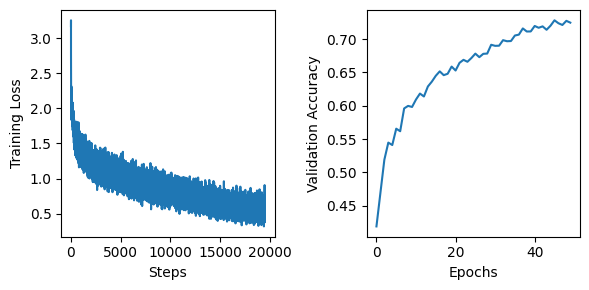

In [5]:
transforms_val = T.Compose([
    T.ToTensor(),
    T.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784]),
])
transforms_train = T.Compose([
    T.RandomHorizontalFlip(),
    T.RandomResizedCrop((32, 32), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    T.ToTensor(),
    T.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784]),
])

model = VisionTransformer().to(device)
optim = torch.optim.Adam(model.parameters(), lr=LR)
loss_fn = nn.CrossEntropyLoss()

dataloader_train = DataLoader(CIFAR10(root=DATASET_CACHE_DIR, train=True, download=True, transform=transforms_train), batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=4)
dataloader_val = DataLoader(CIFAR10(root=DATASET_CACHE_DIR, train=False, download=True, transform=transforms_val), batch_size=BATCH_SIZE, shuffle=False, drop_last=False, num_workers=4)

train_losses = []
val_accs = []

# Measure time
start_time = time.time()

for i_epoch in range(N_EPOCHS):
    for i_step, (images, labels) in (pbar := tqdm(enumerate(dataloader_train), desc=f'Training (Epoch {i_epoch + 1}/{N_EPOCHS})')):
        optim.zero_grad()
        loss = loss_fn(model(images.to(device)), labels.to(device))
        loss.backward()
        optim.step()

        # Some logging
        loss_val = loss.detach().item()
        train_losses.append(loss_val)
        pbar.set_postfix({ 'loss': loss_val } | ({ 'val_acc': val_accs[-1] } if len(val_accs) > 0 else { }))

    # Validation every epoch
    with torch.no_grad():
        n_total, n_correct = 0, 0
        for i_step, (images, labels) in (pbar := tqdm(enumerate(dataloader_val), desc='Validating')):
            predicted = model(images.to(device)).argmax(dim=-1)
            n_correct += (predicted.cpu() == labels).float().sum().item()
            n_total += labels.shape[0]
        val_accs.append(n_correct / n_total)
        print(f'Validation accuracy: {val_accs[-1]:.3f}')

# Measure time
end_time = time.time()
print(f'Training took {end_time - start_time:.2f} seconds.')


plt.figure(figsize=(6, 3))
plt.subplot(121)
plt.plot(train_losses)
plt.xlabel('Steps')
plt.ylabel('Training Loss')
plt.subplot(122)
plt.plot(val_accs)
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.tight_layout()
plt.show()